详细讲解见：[faster_rcnn](faster_rcnn.md)

Loading json in memory ...
used time: 0.868847 s
Loading json in memory ...
creating index...
index created!
used time: 0.405948 s
总共包含图片 2 张
第 1 张图片的高和宽分别为: (612, 612)
第 2 张图片的高和宽分别为: (500, 333)


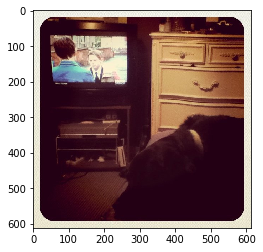

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

# 载入 coco 相关 api
import sys
sys.path.append(r'D:\API\cocoapi\PythonAPI')
from pycocotools.dataset import Loader
%matplotlib inline

dataType = 'val2017'
root = 'E:/Data/coco'
catNms = ['cat', 'dog', 'person']  # 选择包含 'cat', 'dog', 'person' 的图片
annType = 'annotations_trainval2017'

loader = Loader(dataType, catNms, root, annType)

print(f'总共包含图片 {len(loader)} 张')

for i, ann in enumerate(loader.images):
    w, h = ann['height'], ann['width']
    print(f'第 {i+1} 张图片的高和宽分别为: {w, h}')

img, labels = loader[0]
plt.imshow(img);

In [2]:
cd ../app/

D:\API\CV\app


In [3]:
from detection.bbox import MultiBox
from detection.anchor import RPNAnchorGenerator

In [4]:
def getX(img):
    # 将 img (h, w, 3) 转换为 (1, 3, w, h)
    img = img.transpose((2, 1, 0))
    return np.expand_dims(img, 0)

In [5]:
img, label = loader[0]
img = cv2.resize(img, (800, 800))
X = getX(img)
img.shape, X.shape

((800, 800, 3), (1, 3, 800, 800))

In [6]:
from gluoncv.model_zoo import vgg16
from mxnet import nd
net = vgg16(pretrained=True)

In [7]:
imgs = nd.array(X)
x = imgs
for layer in net.features[:29]:
    x = layer(x)
    if "conv" in layer.name:
        print(layer.name, x.shape)

vgg0_conv0 (1, 64, 800, 800)
vgg0_conv1 (1, 64, 800, 800)
vgg0_conv2 (1, 128, 400, 400)
vgg0_conv3 (1, 128, 400, 400)
vgg0_conv4 (1, 256, 200, 200)
vgg0_conv5 (1, 256, 200, 200)
vgg0_conv6 (1, 256, 200, 200)
vgg0_conv7 (1, 512, 100, 100)
vgg0_conv8 (1, 512, 100, 100)
vgg0_conv9 (1, 512, 100, 100)
vgg0_conv10 (1, 512, 50, 50)
vgg0_conv11 (1, 512, 50, 50)
vgg0_conv12 (1, 512, 50, 50)


In [9]:
features = net.features[:29]
xs = features(imgs)
xs.shape

(1, 512, 50, 50)

In [10]:
base_size = 2**4  # 特征图的每个像素的感受野大小
scales = [8, 16, 32]  # 锚框相对于 reference box 的尺度
ratios = [0.5, 1, 2]  # reference box 与锚框的高宽的比率（aspect ratios）
stride = base_size  # 在原图上滑动的步长
alloc_size = (128, 128)  # 一个比较大的特征图的锚框生成模板

A = MultiBox(stride, base_size, ratios, scales, alloc_size)
A.base_anchors.shape

(9, 4)

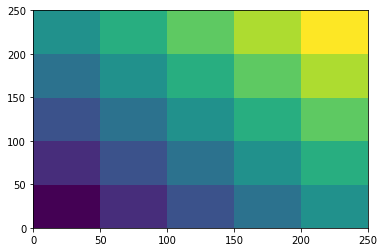

In [11]:
x, y = np.mgrid[0:300:50, 0:300:50]
plt.pcolor(x, y, x+y);  # x和y是网格,z是(x,y)坐标处的颜色值colorbar()

In [12]:
A.anchors.shape

(1, 1, 128, 128, 36)

In [13]:
A.anchors

array([[[[[ -84.,  -38.,   99., ..., -344.,  183.,  359.],
          [ -68.,  -38.,  115., ..., -344.,  199.,  359.],
          [ -52.,  -38.,  131., ..., -344.,  215.,  359.],
          ...,
          [1916.,  -38., 2099., ..., -344., 2183.,  359.],
          [1932.,  -38., 2115., ..., -344., 2199.,  359.],
          [1948.,  -38., 2131., ..., -344., 2215.,  359.]],

         [[ -84.,  -22.,   99., ..., -328.,  183.,  375.],
          [ -68.,  -22.,  115., ..., -328.,  199.,  375.],
          [ -52.,  -22.,  131., ..., -328.,  215.,  375.],
          ...,
          [1916.,  -22., 2099., ..., -328., 2183.,  375.],
          [1932.,  -22., 2115., ..., -328., 2199.,  375.],
          [1948.,  -22., 2131., ..., -328., 2215.,  375.]],

         [[ -84.,   -6.,   99., ..., -312.,  183.,  391.],
          [ -68.,   -6.,  115., ..., -312.,  199.,  391.],
          [ -52.,   -6.,  131., ..., -312.,  215.,  391.],
          ...,
          [1916.,   -6., 2099., ..., -312., 2183.,  391.],
       

In [16]:
A = RPNAnchorGenerator(stride, base_size, ratios, scales, alloc_size)
A.initialize()

A(xs)


[[[ -84.  -38.   99.   53.]
  [-176.  -84.  191.   99.]
  [-360. -176.  375.  191.]
  ...
  [ 748.  704.  835.  879.]
  [ 704.  616.  879.  967.]
  [ 616.  440.  967. 1143.]]]
<NDArray 1x22500x4 @cpu(0)>

In [17]:
x = nd.zeros((1, 3, 75, 45))
A(x).shape

(1, 30375, 4)

In [18]:
class Draft(RPNAnchorGenerator):
    '''
    测试 RPNAnchorGenerator
    '''
    def hybrid_forward(self, F, x, anchors):
        print((x*0).shape)
        a = F.slice_like(anchors, x * 0, axes=(2, 3))
        return a.reshape((1, -1, 4))

In [19]:
alloc_size = (2, 2)  # 为了测试需求，将其改小

B = Draft(stride, base_size, ratios, scales, alloc_size)
B.initialize()
x = nd.zeros((1, 3, 2, 1))
B(x)

(1, 3, 2, 1)



[[[ -84.  -38.   99.   53.]
  [-176.  -84.  191.   99.]
  [-360. -176.  375.  191.]
  [ -56.  -56.   71.   71.]
  [-120. -120.  135.  135.]
  [-248. -248.  263.  263.]
  [ -36.  -80.   51.   95.]
  [ -80. -168.   95.  183.]
  [-168. -344.  183.  359.]
  [ -84.  -22.   99.   69.]
  [-176.  -68.  191.  115.]
  [-360. -160.  375.  207.]
  [ -56.  -40.   71.   87.]
  [-120. -104.  135.  151.]
  [-248. -232.  263.  279.]
  [ -36.  -64.   51.  111.]
  [ -80. -152.   95.  199.]
  [-168. -328.  183.  375.]]]
<NDArray 1x18x4 @cpu(0)>